# Projet Simulation Numérique ENSEEIHT 2022-2023
### Groupe: B
### Nom: MOUTAHIR
### Prénom: Jed
### Commentaire: 

# Informations pratiques

**Modalités pédagogiques** 

Le projet Simulation Numérique vise à vous faire découvrir un algorithme particulier en lien avec d'autres modules d'enseignement de cette année et d'illustrer certaines notions et propriétés à partir de programmes simples que vous devez écrire ou bien compléter. Le langage de programmation proposé est Python. Une connaissance basique de Python et de Numpy est suffisante. 

Cette année, il vous est demandé en premier lieu un travail de compréhension des algorithmes principaux sur la base du C/TD du 10/3/23 et des liens en fin de Notebook. Ensuite est demandé un travail d'implantation informatique simple (partie A) et quelques applications sur des images vous sont proposées (partie B). Ce travail est notamment guidé, des questions de compréhension sur les algorithmes sont posées en Partie C. La partie D vous permet d'implanter un algorithme populaire à titre de comparaison. Le volume de travail demandé est raisonnable.

**Enseignement**

Voici les informations concernant les séances (date, heure):

10/3/23 14.00-16.00 C/TD Groupes B1 et B2 (B306)

14/3/23 14.00-18.00 TP Groupe B1 (C306)

17/3/23 08.00-12.00 TP Groupe B2 (C203)

24/3/23 14.00-16.00 TD Séance de réponse à vos questions (B306)

**Evaluation**

L'évaluation se basera uniquement sur le Notebook que vous devrez rendre. 

**Date limite de rendu**:  19 avril 2023 à midi. 

**Contact**: xavier.vasseur@irit.fr

Merci d'indiquer [PSN] en sujet de votre email pour m'aider à identifier vos requêtes.

**Préambule** L'objectif de ce projet est d'analyser quelques algorithmes de factorisation structurée (déterministe ou aléatoire) de matrices de grande taille. Nous nous intéressons à des algorithmes de factorisation dits "Interpolative Decomposition (ID)" ou "CUR-ID", où l'on cherche à approcher au mieux une matrice en un produit de matrices de rang faible. Les algorithmes seront comparés si possible sous différents angles: temps de calcul, complexité opératoire, précision numérique notamment. Nous envisagerons également l'utilisation d'algorithme dit de factorisation non-négative en fin de projet.

**NB:** Il vous est demandé d'insérer vos commentaires et codes **uniquement** dans ce fichier Notebook. Vous avez toute liberté pour créer des cellules soit de texte soit de code. Vous devez disposer comme données de ce fichier et de quelques images au format .jpg. Le rendu sera uniquement ce fichier Notebook dans lequel vous devez insérer l'ensemble de vos résultats. 

Ce projet est en lien notamment avec les cours suivants:

   * Calcul scientifique
   * Algèbre linéaire pour le data mining
   * Optimisation II

In [1]:
#
# Chargement des bibliotheques pour la visualisation, l'algebre lineaire et l'analyse du temps de calcul 
#
import matplotlib.pyplot as plt
import numpy as np
from   scipy import fftpack
from   scipy.linalg import qr, norm, solve_triangular, svd
from   PIL import Image
import time

### Introduction.

L'approximation de rang faible que nous utiliserons dans ce projet se base sur une connaissance du rang exact ou du rang approché de la matrice étudiée. A titre informatif, la méthode suivante vous permet d'obtenir une majoration du rang d'une matrice rectangulaire $A$ telle que $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$, $\epsilon$ désignant une tolérance choisie par l'utilisateur. Cette méthode sera donc utile par la suite dans vos expérimentations numériques, aucune modification n'est a priori requise. 


In [2]:
def adaptive_rank_determination(A,epsilon,blocking=16,iteration_max=10):
    """
    Adaptive rank determination based on randomization
    We look for an orthogonal matrix Q such that 
    $\|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    where $\|.\|_F$ denotes the Frobenius norm.
    
    Reference: Adapted from Section 12 of P.G. Martinsson, "Randomized methods for matrix computations", 2019, 
    ArXiv 1607.01649 [https://arxiv.org/pdf/1607.01649.pdfs]. The original algorithm corresponds to 
    Figure 12. 
    
    Input: 
    A:        matrix to be analysed [array type] (of shape (m,n))
    epsilon:  relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    blocking: blocking parameter to be used in the implementation (for efficiency reasons) [int]
    
    Output:
    Q: matrix with orthonormal columns such that $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    erank: estimated rank (upper bound of epsilon-rank(A)), erank is here a multiple of min(blocking,n). 
    ratio: current ratio of $\|A - Q Q^T A \|_F4$ divided by $\|A \|_F$
    iteration: nombre d'itérations réalisé au sein de l'algorithme
    """ 
    
    m, n          = A.shape[:]
    # The blocking parameter should be less than the number of columns
    b             = min(blocking,n)
    iteration     = 0
    # Update the maximal number of iterations according to b
    iteration_max = max(np.ceil(n/b),iteration_max) 
    norm_A_Fro = norm(A,'fro')
    
    while norm(A,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        # Create R the random block based on Gaussian variables
        R      = np.random.randn(n,b)
        # Matrix-matrix product Y = AR 
        Y      = A@R
        # QR decomposition of Y
        QY, RY = qr(Y,mode='economic')
        # Compute the projection 
        BY     = QY.T@A
        # Concatenate the information related to Q and B
        if iteration == 0:
            Q  = QY
            B  = BY
        else:
            Q  = np.concatenate((Q, QY),axis=1)
            B  = np.concatenate((B, BY),axis=0)
        # Update the iteration count
        iteration += 1
        # Update of A
        A = A - QY@BY
        # Upper bound of epsilon-rank
        erank = Q.shape[1]
        
    return Q, Q.shape[1], norm(A,'fro')/norm_A_Fro, iteration

## Partie A.1

Proposer une implantation des différents algorithmes de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie C). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [3]:
def column_ID(A,k):
    """
    Compute a column interpolative decomposition such that 
    A \approx A[:,J] Z
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    J  is the set of column indices [array, any type] (of shape k)
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    Z    = np.zeros(shape=(k,n))
    
    #
    # TO DO
    #
    # Perform the economic decomposition of A with column pivoting

    Q, R, P = qr(A, pivoting=True, mode='economic')

    R11, R12 = R[:k, :k], R[:k, k:]
    
    # Deduce the T=R11^{-1}R12 block 
    T = solve_triangular(R11, R12, lower=False)
    
    # Deduce J and Z
    Z[:,P] = np.concatenate((np.identity(k), T), axis=1)
    J = P[:k]
    
    #
    # END TO DO
    #
    
    return J,Z


def row_ID(A,k):
    """
    Compute a row interpolative decomposition such that 
    A \approx X A[I,:] 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array, any type] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k))
    
    #
    # TO DO
    #
    
    # Perform the economic decomposition of A^T with column pivoting

    Q, R, P = qr(A.T, pivoting=True, mode='economic')

    R11, R12 = R[:k, :k], R[:k, k:]

    # Deduce the corresponding T block 
    T = solve_triangular(R11, R12, lower=False)
    
    # Deduce I and X 
    X[P,:] = np.concatenate((np.identity(k), T), axis=1).T
    I = P[:k]

    #
    # END TO DO
    #
    
    return I,X

def double_sided_ID(A,k):
    """
    Compute a double sided interpolative decomposition such that 
    A \approx X A(I,J) Z 
    
    Input: 
    A matrix to be analysed [array type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array] (of shape k)
    J  is the set of column indices [array] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    #
    # TO DO
    #
    
    # Apply the column ID to A
    
    J, Z = column_ID(A, k)
    
    # Apply the row ID to A[:,J]
    
    I, X = row_ID(A[:,J], k)
    
    #
    # END TO DO
    #
    
    return I,J,X,Z

def extract_subblock(A,I,J):
    """
    Given a set of row and column indices, extract the submatrix 
    B = A[I,J]
    with I the set of row indices and J the set of column indices.
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    I  is the set of row indices  (of shape k)
    J  is the set of column indices  (of shape k)
    
    Output:
    Matrix A[I,J] [array] (of shape (k,k))
    """
    B = np.zeros(shape=(len(I),len(J)))
    row_index = 0
    
    for i in I:
        col_index = 0
        for j in J:
            B[row_index,col_index] = A[i,j]
            col_index = col_index + 1
            
        row_index = row_index + 1
    
    return B

def cur(A,k):
    """
    Deterministic version of the CUR algorithm based on the 
    double sided ID decomposition. 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    #
    # TO DO
    #
    
    # Apply the double sided interpolation algorithm
    I,J,X,Z = double_sided_ID(A,k)
    
    # Deduce the C and R matrices of the CUR formulation 
    C = A[:,J]
    R = A[I,:]
    
    # Solve U R = Z in a least-squares sense
    U = Z@(np.linalg.pinv(R))

    #
    # END TO DO
    #
    return I,J,C,U,R

## Partie A.2 

Proposer une implantation des différents algorithmes aléatoires de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie D). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [4]:
def randomized_row_ID(A,k,p=10,q=2):
    """
    Randomized version of the row ID to decompose matrix A into
    A \approx X A(I,:) 
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)
    
    Output:
    I  is the set of row indices  (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.4 and Figure 8 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    
    """
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k)) 
    
    # Use the randomized variant to construct Y an approximation of A
    G    = np.random.randn(n,k+p)
    Y    = A@G
   
    #
    # TO DO
    #
   
    # Perform q power iterations
    for i in range(q):
        Y = A@(A.T@Y)
    
    # Apply the row ID algorithm to Y
    I, X = row_ID(Y, k)

    #
    # END TO DO
    #
    
    return I,X

   
def randomized_cur(A,k,p=10,q=2):
    """
    Randomized version of the CUR algorithm     
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 and Figure 10 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """    
    m, n = A.shape[:]
    
    # Randomized version starts here
    # Use the randomized variant to construct Y an approximation of A
     
    G    = np.random.randn(k+p,m)
    Y    = G@A
    
    #
    # TO DO
    #
    
    # Perform q power iterations
    for i in range(q):
        Y = Y@(A.T@A)

    # Apply the column ID algorithm to Y
    J,Z = column_ID(Y, k)
    
    # Apply the row ID algorithm to A[:,J]
    I,X = randomized_row_ID(A[:,J],k,p,q)
    
    # Deduce the CUR matrices (C, R and then U)
    C = A[:,J]
    R = A[I,:]
    U = Z@(np.linalg.pinv(R))
    
    #
    # END TO DO
    #
    return I,J,C,U,R

## Partie B

Nous cherchons à mettre en oeuvre les algorithmes précédents sur une application liée à la reconstruction d'images.
La cellule suivante vous montre comment charger une image et en déduire la matrice associée. Appliquer alors les algorithmes de 
factorisation vus en Partie A et visualiser les images obtenues en fonction du rang estimé.  

### Sydney

(396, 563)


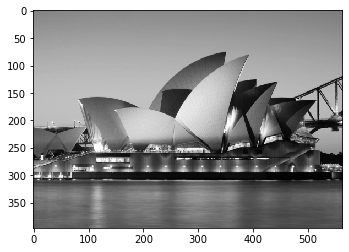

In [5]:
#
# Lecture de l'image 
#
#
imgc = Image.open("Sydney_Opera_House.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Sydney = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M


Time spent in the determination of the approximated epsilon-rank 0.030952930450439453
Estimated upper bound of the epsilon-rank:  80  for relative threshold:  0.05
Frobenius norm ratio:  0.04965871569356296  reached in  5 iterations
Time spent in the CUR algorithm 0.06464576721191406
Time spent in the randomized CUR algorithm 0.042031288146972656
Time spent in the double sided ID algorithm 0.04342079162597656


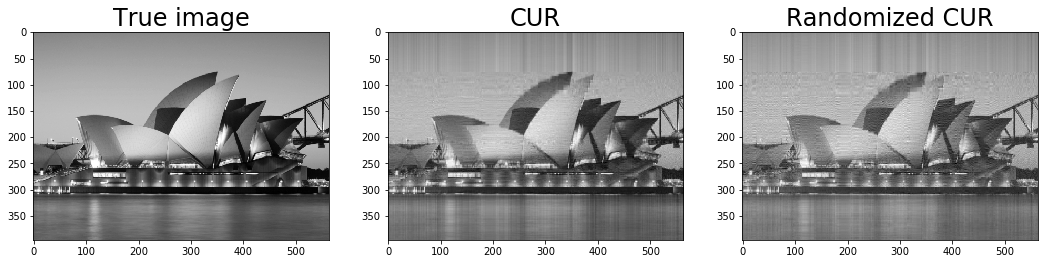

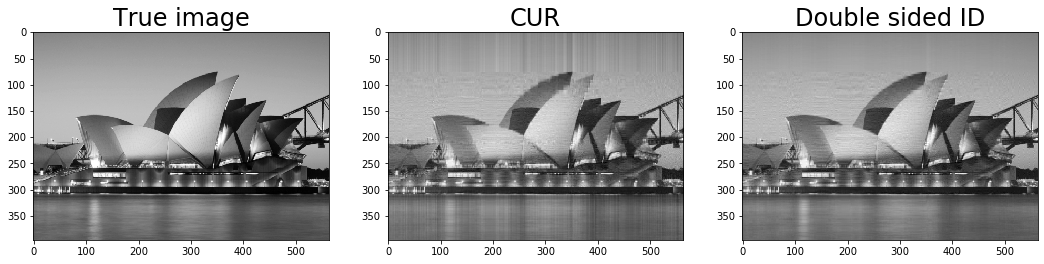

In [6]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Sydney = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_S          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
# Application de l'algorithme ID/CUR

plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_S,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Tokyo

(1008, 1212)


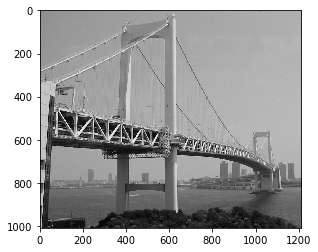

In [7]:
#
# Lecture de l'image 
#
#
#imgc = Image.open("Sydney_Opera_House.jpg")
imgc = Image.open("Tokyo_Rainbow_Bridge.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Tokyo  = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.24758005142211914
Estimated upper bound of the epsilon-rank:  160  for relative threshold:  0.05
Frobenius norm ratio:  0.04727269861436878  reached in  10 iterations
Time spent in the CUR algorithm 0.33254504203796387
Time spent in the randomized CUR algorithm 0.21079325675964355
Time spent in the double sided ID algorithm 0.3374967575073242


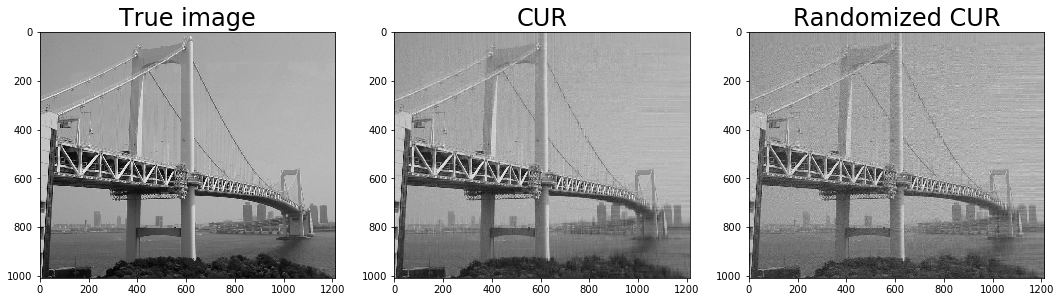

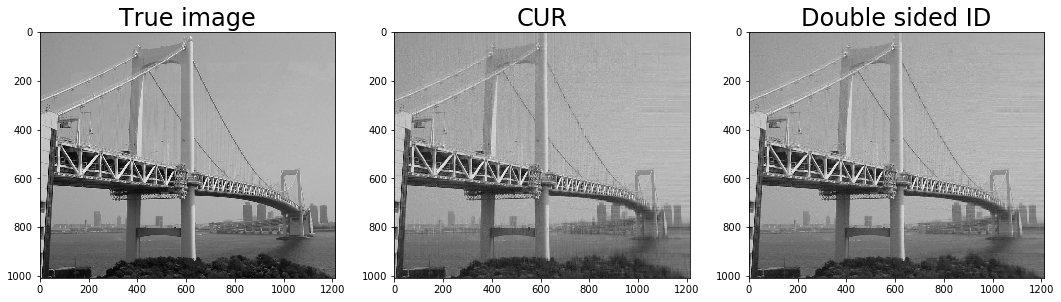

In [8]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Tokyo = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_T          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_T,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Hamburg

(524, 932)


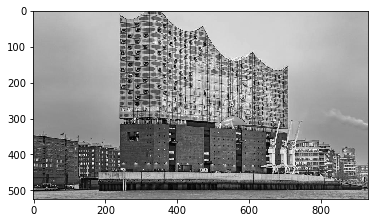

In [9]:
#
# Lecture de l'image [couleur] 
#
#
imgc = Image.open("Hamburg_Elbphilarmonie.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M         = (1./255)*np.array(img_gray)
M_Hamburg = M[:]

print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.17273783683776855
Estimated upper bound of the epsilon-rank:  272  for relative threshold:  0.05
Frobenius norm ratio:  0.04759158324704146  reached in  17 iterations
Time spent in the CUR algorithm 0.12383794784545898
(272, 932)
Time spent in the randomized CUR algorithm 0.19588756561279297
(272, 932)
Time spent in the double sided ID algorithm 0.13716697692871094
(272, 932)


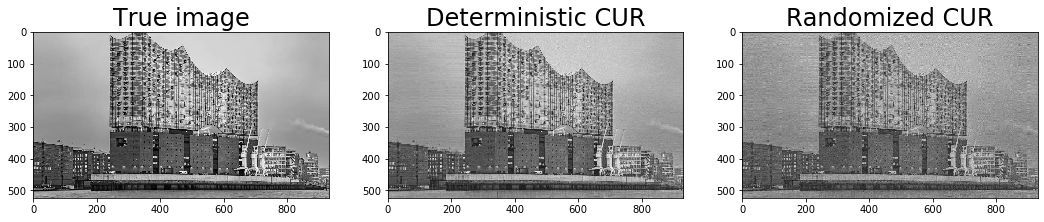

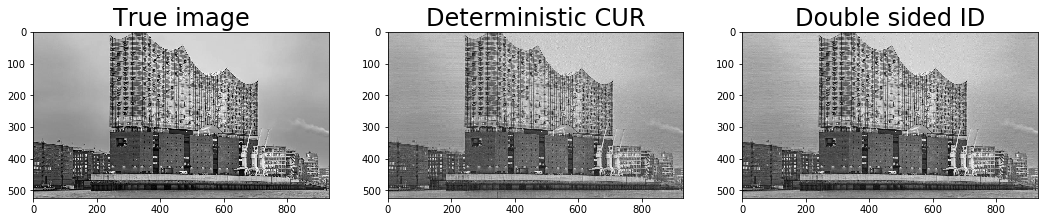

In [10]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Hamburg = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
print(np.shape(R))
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I,J,C, U, R    = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
print(np.shape(R))
#
# Double sided ID
#
t_start  = time.time()
I,J,X,Z  = double_sided_ID(M,erank)
JID_H    = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
print(np.shape(Z))
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_H,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

**Question:**
* B.1 Prenez trois valeurs pour $\epsilon$ (par exemple $\epsilon=0.5$, $\epsilon=0.1$ et $\epsilon=0.05$) et analysez la qualité de l'approximation pour les images considérées. Qu'observez-vous ? 

**Réponse**:
The quality of the approximation is better when $\epsilon$ is smaller. Indeed, when $\epsilon$ is smaller, the approximation is closer to the original image.

**Question:**
* B.2 Observez-vous des différences de qualité de reconstruction entre les algorithmes pour une précision identique ?

**Réponse**:
Yes, the quality of the reconstruction is better for the Double Sided ID algorithm than for the other algorithms. The Deterministic ID algorithm is second and the Randomized ID algorithm is the worst.

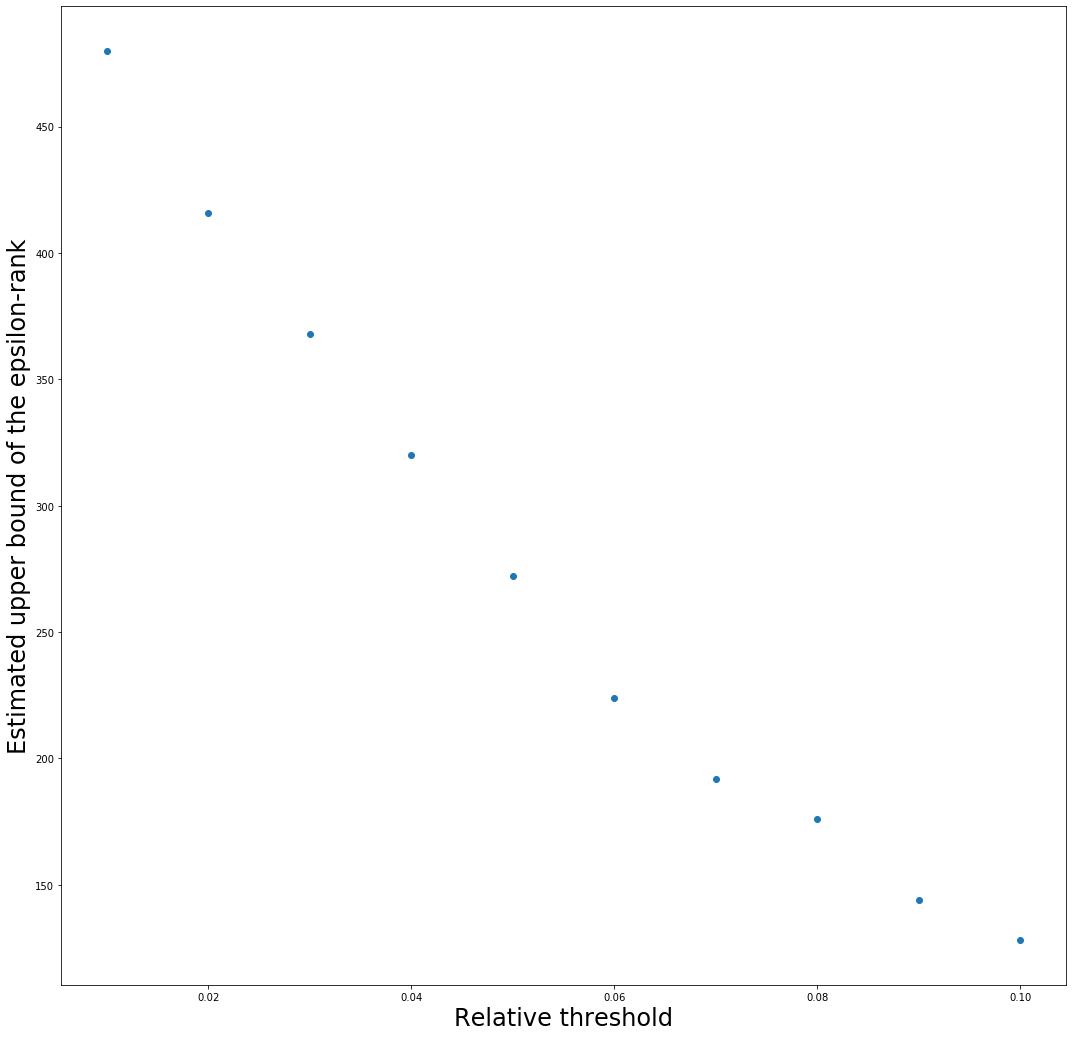

In [11]:
# Evaluation of the quality of the approximation of the image for different values of epsilon

epsilon = np.linspace(0.01,0.1,10)
erank   = np.zeros(np.shape(epsilon))
for i in range(np.shape(epsilon)[0]):
    Q, erank[i], norm_ratio, iteration = adaptive_rank_determination(M,epsilon[i],blocking)
    #print("Estimated upper bound of the epsilon-rank: ",erank[i], " for relative threshold: ",epsilon[i])
    #print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")

plt.figure(figsize=(18,18))
plt.plot(epsilon,erank,'o')
plt.xlabel('Relative threshold',fontsize=24)
plt.ylabel('Estimated upper bound of the epsilon-rank',fontsize=24)
plt.show()


## Partie C.

En vous basant notamment sur les notes de cours, le chapitre 11 de <a href="https://arxiv.org/pdf/1607.01649.pdf">Martinsson (2019)</a>, la section 13 de <a href="https://arxiv.org/pdf/2002.01387.pdf">Martinsson et Tropp (2020)</a>,  répondre aux deux questions suivantes:

* C.1 Donner les avantages et inconvénients éventuels de la décomposition déterministe CUR-ID. 

**Réponse**: 
* Avantages: 
    * The CUR-ID algorithm is more precise than the ID algorithm.
    * The CUR-ID algorithm is more efficient than the ID algorithm.
* Inconvénients:
    * The CUR-ID algorithm is more complex than the ID algorithm.

********
* C.2 Expliquer comment paralléliser l'algorithme aléatoire CUR-ID. 

**Réponse**: In order to parallelize the CUR-ID algorithm, we can use the following method: we can split the matrix $A$ into $n$ blocks $A_1, A_2, ..., A_n$ and we can compute the CUR decomposition of each block $A_i$ in parallel. Then, we can compute the product $A = A_1 A_2 ... A_n$.

## Partie D.

Appliquer l'algorithme de factorisation non-négative de <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Lee et Cheung</a> (Théoreme 1) pour obtenir une approximation d'une image donnée en norme de Frobenius. Une attention sera donnée à l'implantation proposée et au temps de restitution obtenu.  Vous pourrez à cet effet utiliser les fonctions multiply et divide de NumPy.

In [12]:
def nmf(M,erank,epsilon,iteration_max):
    """
    Non-negative matrix factorization for matrix M.
    Input: 
    M:             matrix to be analysed [array type] (of shape (m,n))
    erank:         estimated rank (upper bound of epsilon-rank(M))
    epsilon:       relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    iteration_max: maximal number of iterations [int]
    
    Output:
    X,Y: matrices with positive entries such that $ \|M - X Y \|_F \le \epsilon \|M \|_F$
    iteration: effective number of iterations
    """
    m     = np.shape(M)[0] # nombre de lignes de la matrice M
    n     = np.shape(M)[1] # nombre de colonnes de la matrice M
    
    # Specify two possible first iterates for X and Y
    X = np.random.rand(m,erank) 
    Y = np.random.rand(erank,n)

    # Set variables
    norm_A_Fro    = norm(M,'fro')
    iteration     = 0
    
    # Algorithm 
    while norm(M-X@Y,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        #
        # TO DO
        #
        # Update X and Y using multiply and divide from numpy
        X = np.multiply(X,np.divide(M @ Y.T, X @ Y @ Y.T))
        Y = np.multiply(Y,np.divide(X.T @ M, X.T @ X @ Y))

        #X = X * (M @ Y.T) / (X @ Y @ Y.T)
        #Y = Y * (X.T @ M) / (X.T @ X @ Y)

        iteration = iteration + 1

        #
        # END TO DO
        #
        if iteration%25 == 0:
            print(iteration,norm(M-X@Y,'fro')/norm_A_Fro)

    return X,Y,iteration

25 0.2263897542960281
50 0.17764872125199063
75 0.14590493921607045
100 0.12558177023287984
125 0.11221635938790352
150 0.10285248315957041
175 0.09592805328948162
200 0.0905868444028308
225 0.08634798804508295
250 0.08290543461650954
275 0.0800523447796454
300 0.07764378102043469
325 0.07557840509325928
350 0.07378461434458398
375 0.07221048762701752
400 0.07081704191243278
425 0.06957446613911178
450 0.06845939542066841
475 0.06745303189679198
500 0.06653999046702049
525 0.06570757828903527
550 0.0649452679264323
575 0.06424430427795466
600 0.06359728724656052
625 0.06299793222583036
650 0.06244087201232958
675 0.06192149527359852
700 0.06143610681288619
725 0.060981394397434475
750 0.06055433398871113
775 0.06015227656393608
800 0.05977288849828324
825 0.05941415398038156
850 0.05907433689628985
875 0.05875190369985578
900 0.05844543787093513
925 0.05815371043247542
950 0.05787575240312334
975 0.0576106312884539
1000 0.05735744517265682
1025 0.05711536646378316
1050 0.05688362604657

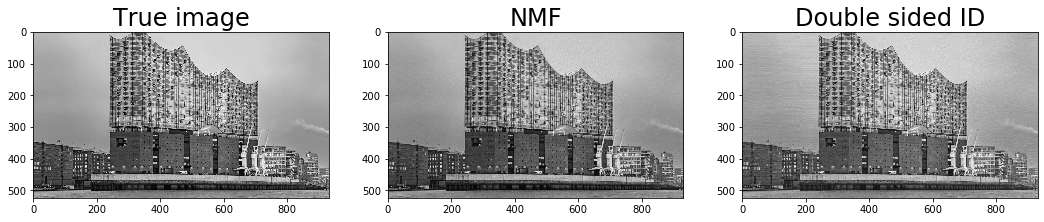

In [13]:
#
# Specify one of the target images here
#
erank = erank_Hamburg
M     = M_Hamburg[:]
JID   = JID_H[:]
#
# NMF 
#
iteration_max = 3500
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

25 0.2060309533586797
50 0.1332276297610525
75 0.10656459519767862
100 0.09181162660563219
125 0.08188671100881875
150 0.0748422766485462
175 0.0696428537370625
200 0.06567226334087674
225 0.06256866801933245
250 0.06008853756664565
275 0.0580647078214242
300 0.05638152141872325
325 0.05495648187985818
350 0.05373002781063709
375 0.05265938162603088
400 0.05171377121716473
425 0.05087078227856463
450 0.05011389023045358
Time spent in the non-negative matrix factorization (NMF) 2.36213755607605
Norm ratio:  0.04999989924620418  reached in  454 iterations


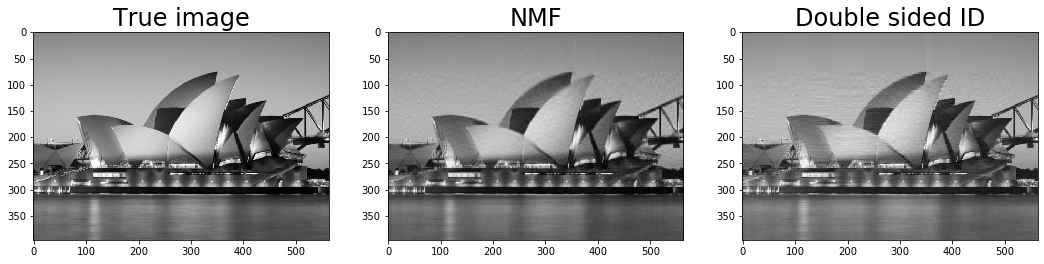

In [14]:
#
# Specify one of the target images here
#
erank = erank_Sydney
M     = M_Sydney[:]
JID   = JID_S[:]
#
# NMF 
#
iteration_max = 2000
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

25 0.20091166373659705
50 0.1557321636171968
75 0.12822825342477007
100 0.10719762381854292
125 0.09369205701748999
150 0.08493393170100483
175 0.07879464220919322
200 0.07418840573657835
225 0.07054917711336509
250 0.06756852747163881
275 0.06506892944168045
300 0.06293914992320539
325 0.061101439239806724
350 0.05949842689006244
375 0.05808658553130497
400 0.056832248827017845
425 0.05570911407909075
450 0.054696552395057656
475 0.05377831485996706
500 0.05294145027686912
525 0.05217541536901808
550 0.05147145493024795
575 0.05082223649713487
600 0.050221610485847945
Time spent in the non-negative matrix factorization (NMF) 23.638344287872314
Norm ratio:  0.049993777552712164  reached in  610 iterations


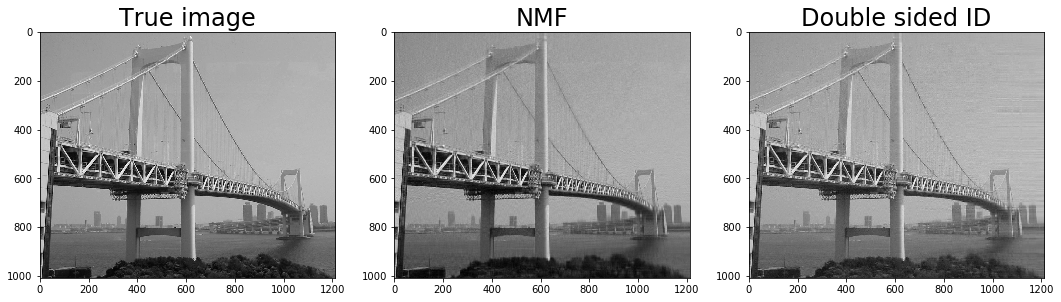

In [15]:
#
# Specify one of the target images here
#
erank = erank_Tokyo
M     = M_Tokyo[:]
JID   = JID_T[:]
#
# NMF 
#
iteration_max = 2000
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Questions:

* D.1 Pour $\epsilon=0.05$, indiquer pour chacune des images le temps de restitution et le nombre d'itérations. Commenter la vitesse de convergence de la méthode et la qualité de l'image reconstruite.

**Réponse**:
* Hamburg: 2975 iterations in 81.0 seconds
* Sydney: 454 iterations in 2.4 seconds
* Tokyo: 610 iterations in 23.6 seconds

The quality of the reconstruction is better than the quality of the reconstruction obtained with the CUR-ID algorithm.
The speed of convergence depends a lot on the initial image. It is generally slower than the speed of convergence of the CUR-ID algorithm.
********
* D.2 A chaque fois, nous avons considéré une image exacte dans chacun des algorithmes pour en déduire une approximation de rang faible. Comment obtenir une approximation de rang faible si l'on dispose uniquement d'une image de qualité médiocre comme image initiale ? Proposez un algorithme. 

**Réponse**: **TODO**


* Bonus Quel(s) algorithme(s) utiliseriez-vous pour approcher (au sens de l'approximation de rang faible) non pas une image mais une séquence d'images (donnée par exemple au sein d'une video) ? 

**Réponse**: We can use the fastest algorithm to approximate the sequence of images. In our case, the fastest algorithm is the CUR-ID algorithm.

### Références  (articles et exposés)

## Articles

* D. Lee and S. Cheung. <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Algorithms for Non-negative Matrix Factorization </a>. Advances in Neural Information Processing Systems 13 (NIPS 2000). 


* P.-G.  Martinsson.  <a href="https://arxiv.org/pdf/1607.01649.pdf">Randomized  methods  for  matrix  computations</a>.  In  M.W.  Mahoney,  J.C.  Duchi,  and  A.C.  Gilbert, editors, The Mathematics of Data, volume 25, chapter 4, pages 187 – 231. American Mathematical Society, IAS/ParkCity Mathematics Series, 2018.


* P.-G.  Martinsson and J. Tropp.  <a href="https://arxiv.org/pdf/2002.01387.pdf">Randomized Numerical Linear Algebra: Foundations & Algorithms</a>. Acta Numerica, 29, pp 403-572, 2020.


* S. Voronin, P.-G.  Martinsson and  <a href="https://users.oden.utexas.edu/~pgm/Pubs/2017_voronin_CUR.pdf">Efficient Algorithms for CUR and Interpolative Matrix Decompositions</a>. Advances in Computational Mathematics, Volume 43, Issue 3, pp 495–516, 2017.

## Exposés

* P.-G.  Martinsson. <a href="https://simons.berkeley.edu/talks/randomized-algorithms-computing-full-matrix-factorizations">Randomized Algorithms for Computing Full Matrix Factorizations</a>, talk given at  
Randomized Numerical Linear Algebra and Applications, September 2018, Simons Institute, Berkeley, 2018.


* P.-G.  Martinsson. <a href="https://www.youtube.com/watch?v=l262Qij6flM">Randomized algorithms for pivoting and for computing interpolatory and CUR factorizations</a>, talk given at E-Numerical Linear Algebra seminars, March 2021.
